In [1]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import holoviews as hv
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product. Instead of reshaping (or re-indexing) our data, we will extract the pure values and use `pandas` to pivot everything

In [2]:
ds_grib_6hr = xr.load_dataset('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib', 
                          engine='cfgrib')
ds_grib_6hr

<xarray.Dataset>
Dimensions:     (time: 736, values: 542080)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
Dimensions without coordinates: values
Data variables:
    t2m         (time, values) float32 247.30748 247.49889 ... 225.18036
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-30T10:48:39 GRIB to CDM+CF via cfgrib-0....

### Load 12-hrs data (just for testing)

In [3]:
ds_grib_12hr = xr.load_dataset('../cdsapi_requested_files/cds_dec07-feb08_12hrs.grib', 
                          engine='cfgrib')
ds_grib_12hr

<xarray.Dataset>
Dimensions:     (time: 184, values: 542080)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
Dimensions without coordinates: values
Data variables:
    t2m         (time, values) float32 247.30748 247.49889 ... 224.41501
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-30T10:49:04 GRIB to CDM+CF via cfgrib-0....

Now that the data is loaded, we can use `xarray` to aggregate to the week level. The array has a time coordinate, and the shape of the data array is `(time, values)`, so we can aggregate across rows keeping the same number of columns but only with rows columns (weeks)

In [4]:
ds_week_resample_6hr = ds_grib_6hr.resample(time='1W').mean()
ds_week_resample_12hr = ds_grib_12hr.resample(time='1W').mean()

### Pandas magic: load data as pd.DataFrame()

In [5]:
ds_week_df_6hr = ds_week_resample_6hr.to_dataframe().filter(['latitude', 'longitude', 't2m'])
ds_week_df_12hr = ds_week_resample_12hr.to_dataframe().filter(['latitude', 'longitude', 't2m'])

In [18]:
ds_week_df_times = ds_week_df_6hr.merge(ds_week_df_12hr,
                                        right_index=True,
                                        left_index=True,
                                        suffixes=('_6_hr','_12hr')
                                       )

###  _Fancy_ area calculation

In [25]:
def fancy_area(lat_array): 
    '''
    Calculate areas using science instead of g'old brute force
    
    :param lat_arrays np.array: Numpy or panda.Series of latitudes
    
    :returns: Area array in kilometers
    '''
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # Fancy calulation
    lat_array_radians = lat_array * (np.pi/180)
    areas = (R_earth*dphi)**2 * np.cos(lat_array_radians)
    
    return areas

In [30]:
# Calculate *fancy* area and get only northern hemisphere ~ México Lindo y Querido!
ds_week_df_times = ds_week_df_times[ds_week_df_times.latitude_6_hr > 20]
ds_week_df_times['area_grid'] = ds_week_df_times.latitude_6_hr.apply(lambda x: fancy_area(x))

<ipython-input-30-199814dd1d66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_week_df_times['area_grid'] = ds_week_df_times.latitude_6_hr.apply(lambda x: fancy_area(x))


### Create temperature bins (each 5° K) and create cut-offs in data.frame

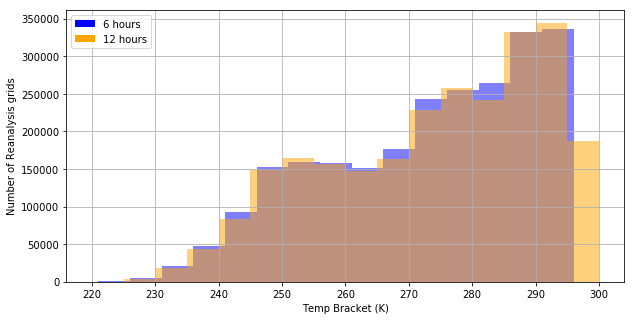

In [41]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize = (10, 5))
ds_week_df_times.t2m_6_hr.hist(bins = range(int(min(ds_week_df_times.t2m_6_hr)),
                                int(max(ds_week_df_times.t2m_6_hr)),
                                5),
                               color='blue',
                               alpha=0.5)
ds_week_df_times.t2m_12hr.hist(bins = range(int(min(ds_week_df_times.t2m_12hr)),
                                int(max(ds_week_df_times.t2m_12hr)),
                                5),
                               color='orange',
                               alpha=0.5)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')

legend_elements = [Patch(facecolor='blue', label='6 hours'),
                   Patch(facecolor='orange',label='12 hours')
                  ]

ax.legend(handles=legend_elements)

In [46]:
# Make cut-offs with 12-hours (more spread)
cut_off = pd.interval_range(start=int(min(ds_week_df_times.t2m_12hr)), 
                            end=int(max(ds_week_df_times.t2m_12hr)) + 5, 
                            freq=5)

ds_week_df_times = ds_week_df_times.assign(temp_bracket=pd.cut(ds_week_df_times['t2m_12hr'], 
                                                               cut_off, 
                                                               right=True)).\
reset_index(drop=False)

In [49]:
# Calculate count of grids per group: time and temperature range
ds_week_df_north_group = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)[['latitude_6_hr', 'latitude_12hr']].\
count().\
rename(columns = {'latitude_6_hr': 'number_grids_6hr',
                 'latitude_12hr': 'number_grids_12hr'}
      )

ds_week_df_north_group = ds_week_df_north_group.assign(
    grids_cumsum_6hr = ds_week_df_north_group.number_grids_6hr.cumsum(),
    grids_cumsum_12hr = ds_week_df_north_group.number_grids_12hr.cumsum(),
    left_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.right)
)

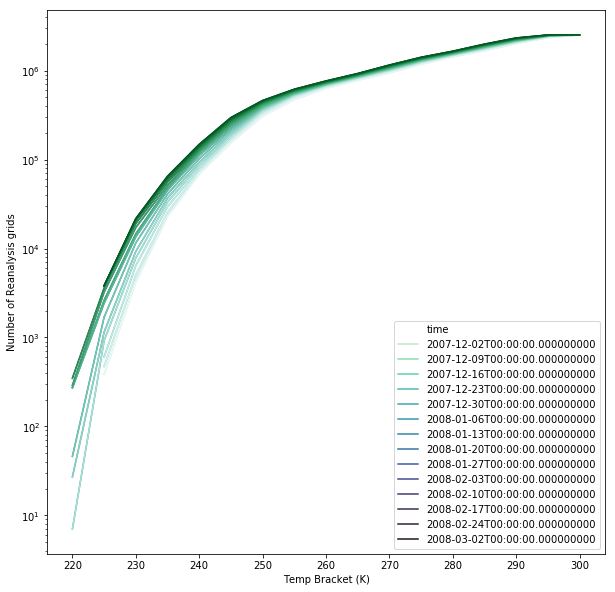

In [55]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="grids_cumsum_6hr", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group)
sns.lineplot(x="left_temp_interval", 
             y="grids_cumsum_12hr",
             palette=sns.color_palette("BuGn", 14),
             hue='time',
             data=ds_week_df_north_group,
             ax=ax,
             legend=False)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')
plt.yscale('log')

###  Calculate weekly temperature bucket covered area in the northern hemisphere [$latitude > 20$]

In [57]:
# Calculate sum of grid area per group: time and temperature range
ds_week_df_north_group_area = ds_week_df_north_group.\
groupby(['temp_bracket', 'time'], as_index=False)[['area_grid']].\
sum().\
rename(columns = {'area_grid_6hr': 'total_area_grid_6hr'})

# There must be a better way of doing this (maybe .agg method?)
ds_week_df_north_group_area['grids_cumsum_area_6hr'] = ds_week_df_north_group_area.\
groupby('time').\
total_area_grid.\
cumsum()

ds_week_df_north_group_area['grids_cumsum_area_12hr'] = ds_week_df_north_group_area.\
groupby('time').\
total_area_grid.\
cumsum()

ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    left_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.right)
)

KeyError: "Columns not found: 'area_grid_6hr', 'area_grid_12hr'"

In [332]:
print(ds_week_df_north_group_area[ds_week_df_north_group_area.time == '2007-12-02'].
     filter(['temp_bracket', 'time', 'grids_cumsum_area']))

    temp_bracket       time  grids_cumsum_area
0     (220, 225] 2007-12-02                NaN
14    (225, 230] 2007-12-02       7.376136e+03
28    (230, 235] 2007-12-02       9.375721e+04
42    (235, 240] 2007-12-02       4.639127e+05
56    (240, 245] 2007-12-02       1.644608e+06
70    (245, 250] 2007-12-02       3.534508e+06
84    (250, 255] 2007-12-02       7.019525e+06
98    (255, 260] 2007-12-02       1.070978e+07
112   (260, 265] 2007-12-02       1.618494e+07
126   (265, 270] 2007-12-02       2.239332e+07
140   (270, 275] 2007-12-02       2.888399e+07
154   (275, 280] 2007-12-02       3.947329e+07
168   (280, 285] 2007-12-02       4.922999e+07
182   (285, 290] 2007-12-02       6.238168e+07
196   (290, 295] 2007-12-02       8.001954e+07
210   (295, 300] 2007-12-02       9.448961e+07
224   (300, 305] 2007-12-02       9.478785e+07


/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


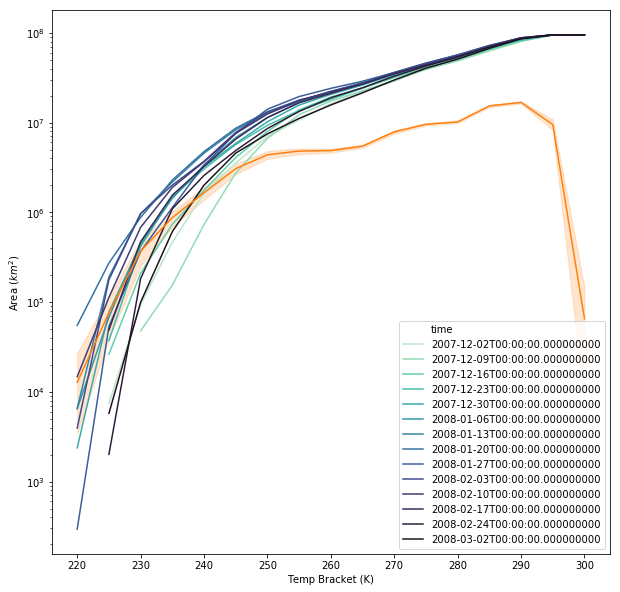

In [308]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="grids_cumsum_area", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
sns.lineplot(x="left_temp_interval", 
             y="total_area_grid",
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area,
             ax=ax)
ax.set(xlabel='Temp Bracket (K)', ylabel=r'Area ($km^{2}$)')
plt.yscale('log')

### Calculate effective latitude using math!

We can calculate the effective $(\varphi)$ latitude using the following formula:
$$
Area = 2 \pi r^{2} (1 - sin( \varphi) )
$$

From this we can rearange the equation to get: 

$$
1 - \frac{A}{2\pi r^{2}} = arcsin(\varphi)
$$

In [319]:
def eff_latitude(cdf_areas):
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    pdf_lat_effs =  np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    
    return pdf_lat_effs

In [328]:
ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    eff_lat = ds_week_df_north_group_area.grids_cumsum_area.apply(lambda x: eff_latitude(x))
) 

ds_week_df_north_group_area['eff_lat_cumsum'] = ds_week_df_north_group_area.\
groupby('time').\
eff_lat.\
fillna(0).\
cumsum(skipna=False)

In [329]:
ds_week_df_north_group_area[ds_week_df_north_group_area.time == '2007-12-02'].eff_lat_cumsum.describe()

count     17.000000
mean     138.579242
std       82.983031
min        0.000000
25%       74.363952
50%      148.133128
75%      208.416226
max      252.120800
Name: eff_lat_cumsum, dtype: float64

[Text(0,0.5,'Effective Latitude [$\\varphi$] (radians)'),
 Text(0.5,0,'Temp Bracket (K)')]

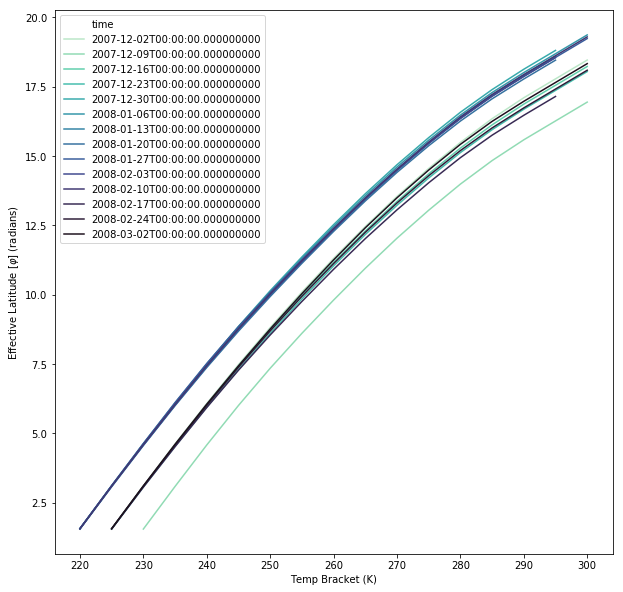

In [315]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="eff_lat_cumsum", 
             hue='time', 
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
ax.set(xlabel="Temp Bracket (K)", ylabel=r'Effective Latitude [$\varphi$] (radians)')

In [43]:
# Export to CSV for comparison
out_data = air_week_df_group_north_cdf_area
out_data['right_temp_interval'] = out_data.temp_bracket.apply(lambda x: x.right)
out_data = out_data.filter(['time', 'left_temp_interval', 'right_temp_interval', 'eff_latitude'])
out_data_sort = out_data.sort_values(['time', 'left_temp_interval'], ascending=True)

out_data_sort.to_csv('t2m_per_eff_latitude.csv', index=False)

In [44]:
out_data_sort

,time,left_temp_interval,right_temp_interval,eff_latitude
0,2007-12-02,221,226,NaN
14,2007-12-02,226,231,1.538937
28,2007-12-02,231,236,1.461548
42,2007-12-02,236,241,1.320936
56,2007-12-02,241,246,1.152265
...,...,...,...,...
153,2008-03-02,271,276,-1.226332
167,2008-03-02,276,281,NaN
181,2008-03-02,281,286,NaN
195,2008-03-02,286,291,NaN


<h3><center>Amanda's Test (and data comparison: 12 hr vs 6-hr)!</center></h3>

In [280]:
# Create subset data and equal cuts
test = ds_week_df_north[ds_week_df_north.time == '2007-12-02'].\
groupby('temp_bracket', as_index=False)['area_grid'].\
sum()

test['area_cumsum'] = test.area_grid.fillna(0).cumsum(skipna=False)
print(test)

   temp_bracket     area_grid   area_cumsum
0    (220, 225]  0.000000e+00  0.000000e+00
1    (225, 230]  7.376136e+03  7.376136e+03
2    (230, 235]  8.638108e+04  9.375721e+04
3    (235, 240]  3.701555e+05  4.639127e+05
4    (240, 245]  1.180695e+06  1.644608e+06
5    (245, 250]  1.889900e+06  3.534508e+06
6    (250, 255]  3.485017e+06  7.019525e+06
7    (255, 260]  3.690253e+06  1.070978e+07
8    (260, 265]  5.475165e+06  1.618494e+07
9    (265, 270]  6.208379e+06  2.239332e+07
10   (270, 275]  6.490670e+06  2.888399e+07
11   (275, 280]  1.058930e+07  3.947329e+07
12   (280, 285]  9.756696e+06  4.922999e+07
13   (285, 290]  1.315170e+07  6.238168e+07
14   (290, 295]  1.763785e+07  8.001954e+07
15   (295, 300]  1.447008e+07  9.448961e+07
16   (300, 305]  2.982336e+05  9.478785e+07


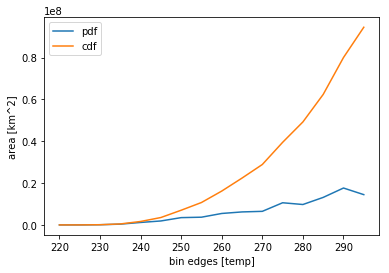

In [339]:
def plots(binedges,pdf,cdf,ylab):
    plt.plot(binedges,pdf,label='pdf')
    plt.plot(binedges,cdf,label='cdf')
    plt.xlabel('bin edges [temp]')
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    #this is the area of each grid cell
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # This is hardcoded!
    Tbins = range(int(ds_week_df_north.t2m.min()),int(ds_week_df_north.t2m.max()), 5)
    #Amanda's bins!
    #Tbins = range(218, 311, 5)
    
    #Function starts here
    lat_rad = lat * (np.pi/180)
    
    areas = (R_earth*dphi)**2 * np.cos(lat_rad)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        plots(binedges[:-1],pdf_areas,cdf_areas,'area [km^2]')

    return binedges[:-1], pdf_areas, cdf_areas

# Create subset data and equal cuts
ds_week_df_north = ds_week_df[ds_week_df.latitude > 20].reset_index(drop=False)
Tbins = range(int(ds_week_df_north.t2m.min()),int(ds_week_df_north.t2m.max()), 5)

test = ds_week_df_north[(ds_week_df_north.time == '2007-12-02')]

binedgs, pdf_area,cdf_area = dists_of_areas(test.t2m, test.latitude, plot=True)

In [340]:
print(
pd.DataFrame({'bins': binedgs,
            'pdf_area': pdf_area,
            'cdf_area': cdf_area})
)

    bins      pdf_area      cdf_area
0    220  0.000000e+00  0.000000e+00
1    225  7.376136e+03  7.376136e+03
2    230  8.638108e+04  9.375721e+04
3    235  3.701555e+05  4.639127e+05
4    240  1.180695e+06  1.644608e+06
5    245  1.889900e+06  3.534508e+06
6    250  3.485017e+06  7.019525e+06
7    255  3.689987e+06  1.070951e+07
8    260  5.472930e+06  1.618244e+07
9    265  6.210646e+06  2.239309e+07
10   270  6.489771e+06  2.888286e+07
11   275  1.058990e+07  3.947276e+07
12   280  9.756025e+06  4.922878e+07
13   285  1.315222e+07  6.238100e+07
14   290  1.763505e+07  8.001605e+07
15   295  1.447356e+07  9.448961e+07


In [ ]:
array([0.00000000e+00, 1.24345111e+03, 4.52785594e+04, 2.52375020e+05,
       1.09955965e+06, 2.70551112e+06, 5.41877087e+06, 9.25519620e+06,
       1.36094762e+07, 1.97595232e+07, 2.59713011e+07, 3.53327313e+07,
       4.55785077e+07, 5.54954993e+07, 7.28509067e+07, 9.04430135e+07,
       9.47878486e+07, 9.47878486e+07])

In [284]:
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    cdf_lat_effs = np.cumsum(pdf_lat_effs)
    if plot:
        plots(binedges,pdf_lat_effs,pdf_lat_effs,'effective lat')
    return pdf_lat_effs, cdf_lat_effs

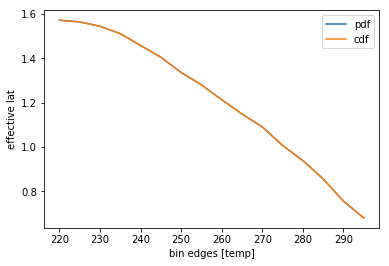

(array([1.57079633, 1.56318652, 1.54366483, 1.5104373 , 1.45710608,
        1.40402321, 1.33550045, 1.2798075 , 1.21244715, 1.14837194,
        1.08999068, 1.00666388, 0.93864175, 0.85584975, 0.75584424,
        0.68037995]),
 array([ 1.57079633,  3.13398285,  4.67764767,  6.18808497,  7.64519105,
         9.04921426, 10.38471471, 11.66452221, 12.87696936, 14.0253413 ,
        15.11533197, 16.12199586, 17.0606376 , 17.91648736, 18.67233159,
        19.35271154]))

In [285]:
dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)

###  Count weekly number of grids per temperature bucket (in the northern hemisphere [$latitude > 20$])